### 📦 1. Import Libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import warnings
warnings.filterwarnings("ignore")
print("Libraries imported successfully.")


Libraries imported successfully.


### 📂 2. Load Dataset

In [2]:

df = pd.read_csv("df_cluster_4.csv")
X = df.drop(columns=['Cluster', 'Bankrupt?', 'Index'])
y = df['Bankrupt?']
print(f"Data shape: {df.shape}")


Data shape: (1186, 31)


### 🌟 3. Feature Selection - Top 5 Features

In [3]:

rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X, y)
top_5_features = pd.Series(rf_selector.feature_importances_, index=X.columns).sort_values(ascending=False).head(5).index.tolist()
X = X[top_5_features]
print("Top 5 Features Selected:")
print(top_5_features)


Top 5 Features Selected:
[' Net Value Growth Rate', ' Total expense/Assets', ' Total debt/Total net worth', ' Current Ratio', ' ROA(C) before interest and depreciation before interest']


### 🔥 4. Base Models Evaluation


Random Forest Accuracy: 0.9874, TT: 1171, TF: 15
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1175
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1186
   macro avg       0.50      0.50      0.50      1186
weighted avg       0.98      0.99      0.98      1186



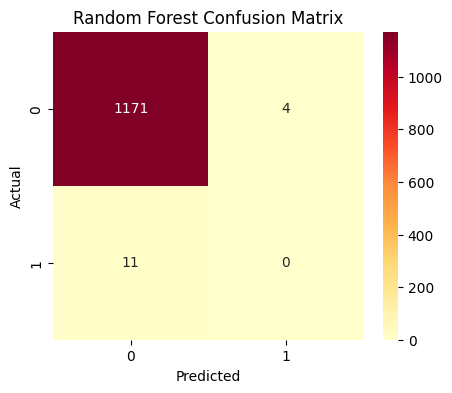


KNN Accuracy: 0.9907, TT: 1175, TF: 11
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1175
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1186
   macro avg       0.50      0.50      0.50      1186
weighted avg       0.98      0.99      0.99      1186



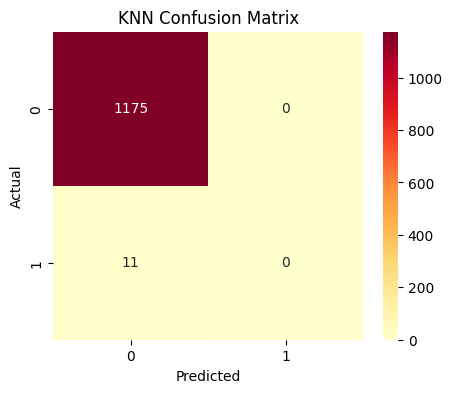


Gradient Boosting Accuracy: 0.9857, TT: 1169, TF: 17
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1175
           1       0.20      0.18      0.19        11

    accuracy                           0.99      1186
   macro avg       0.60      0.59      0.59      1186
weighted avg       0.98      0.99      0.99      1186



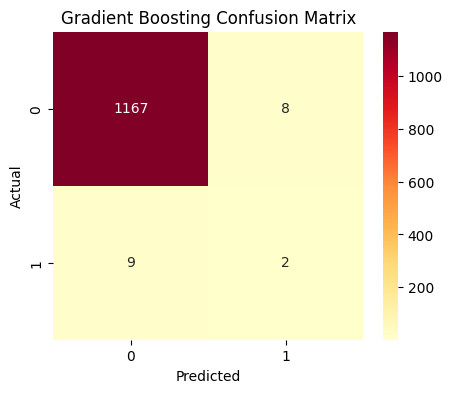

In [9]:

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
base_accs = []
tt_list, tf_list = [], []

for name, model in models.items():
    preds = cross_val_predict(model, X, y, cv=cv)
    acc = np.mean(preds == y)
    cm = confusion_matrix(y, preds)
    TT = cm[0, 0] + cm[1, 1]
    TF = cm[0, 1] + cm[1, 0]
    tt_list.append(TT)
    tf_list.append(TF)
    base_accs.append(acc)
    print(f"\n{name} Accuracy: {acc:.4f}, TT: {TT}, TF: {TF}")
    print(classification_report(y, preds))
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


### 🧠 5. Meta Model - Stacking Classifier


Stacking Model Accuracy: 0.9907, TT: 1175, TF: 11
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1175
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1186
   macro avg       0.50      0.50      0.50      1186
weighted avg       0.98      0.99      0.99      1186



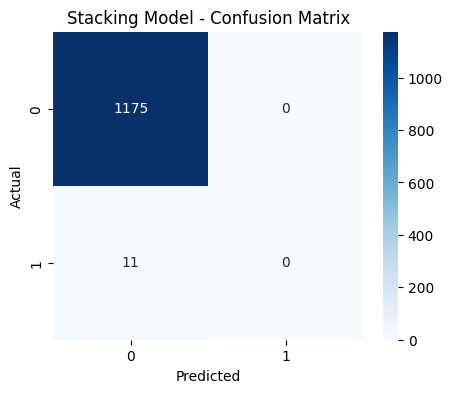

In [ ]:

from sklearn.ensemble import StackingClassifier

base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier()),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
]

meta_model = LogisticRegression(max_iter=1000, random_state=42)
stacking_model = StackingClassifier(estimators=base_estimators, final_estimator=meta_model, cv=5)

stack_preds = cross_val_predict(stacking_model, X, y, cv=cv)
stack_acc = np.mean(stack_preds == y)
cm_stack = confusion_matrix(y, stack_preds)
TT_stack = cm_stack[0, 0] + cm_stack[1, 1]
TF_stack = cm_stack[0, 1] + cm_stack[1, 0]

print(f"\nStacking Model Accuracy: {stack_acc:.4f}, TT: {TT_stack}, TF: {TF_stack}")
print(classification_report(y, stack_preds))

plt.figure(figsize=(5, 4))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='YlOrRd')
plt.title("Stacking Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### 📊 6. TT vs TF Visualizations (Meta Model Only)

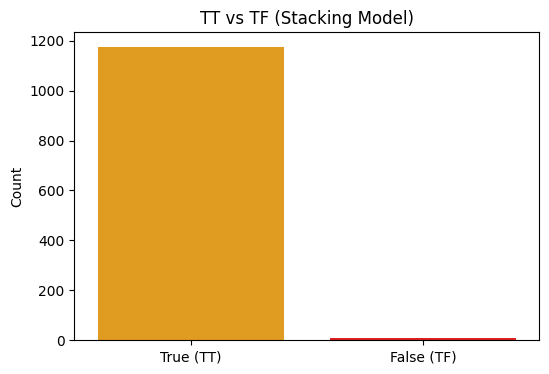

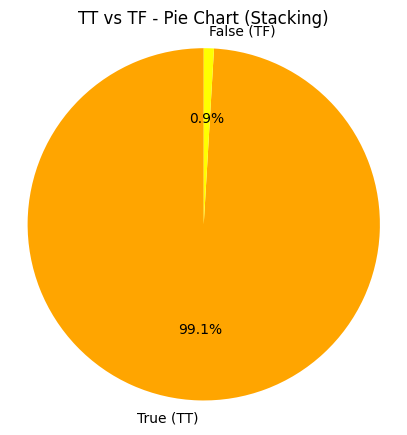

In [17]:

labels = ['True (TT)', 'False (TF)']
values = [TT_stack, TF_stack]

# Bar Chart
plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=values,palette=['orange', 'red'])
plt.title("TT vs TF (Stacking Model)")
plt.ylabel("Count")
plt.show()

# Pie Chart
plt.figure(figsize=(5, 5))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['orange','yellow'])
plt.title("TT vs TF - Pie Chart (Stacking)")
plt.axis('equal')
plt.show()



Training stacking model fully on the entire cluster 3 data

Plotting feature importances from Random Forest base model


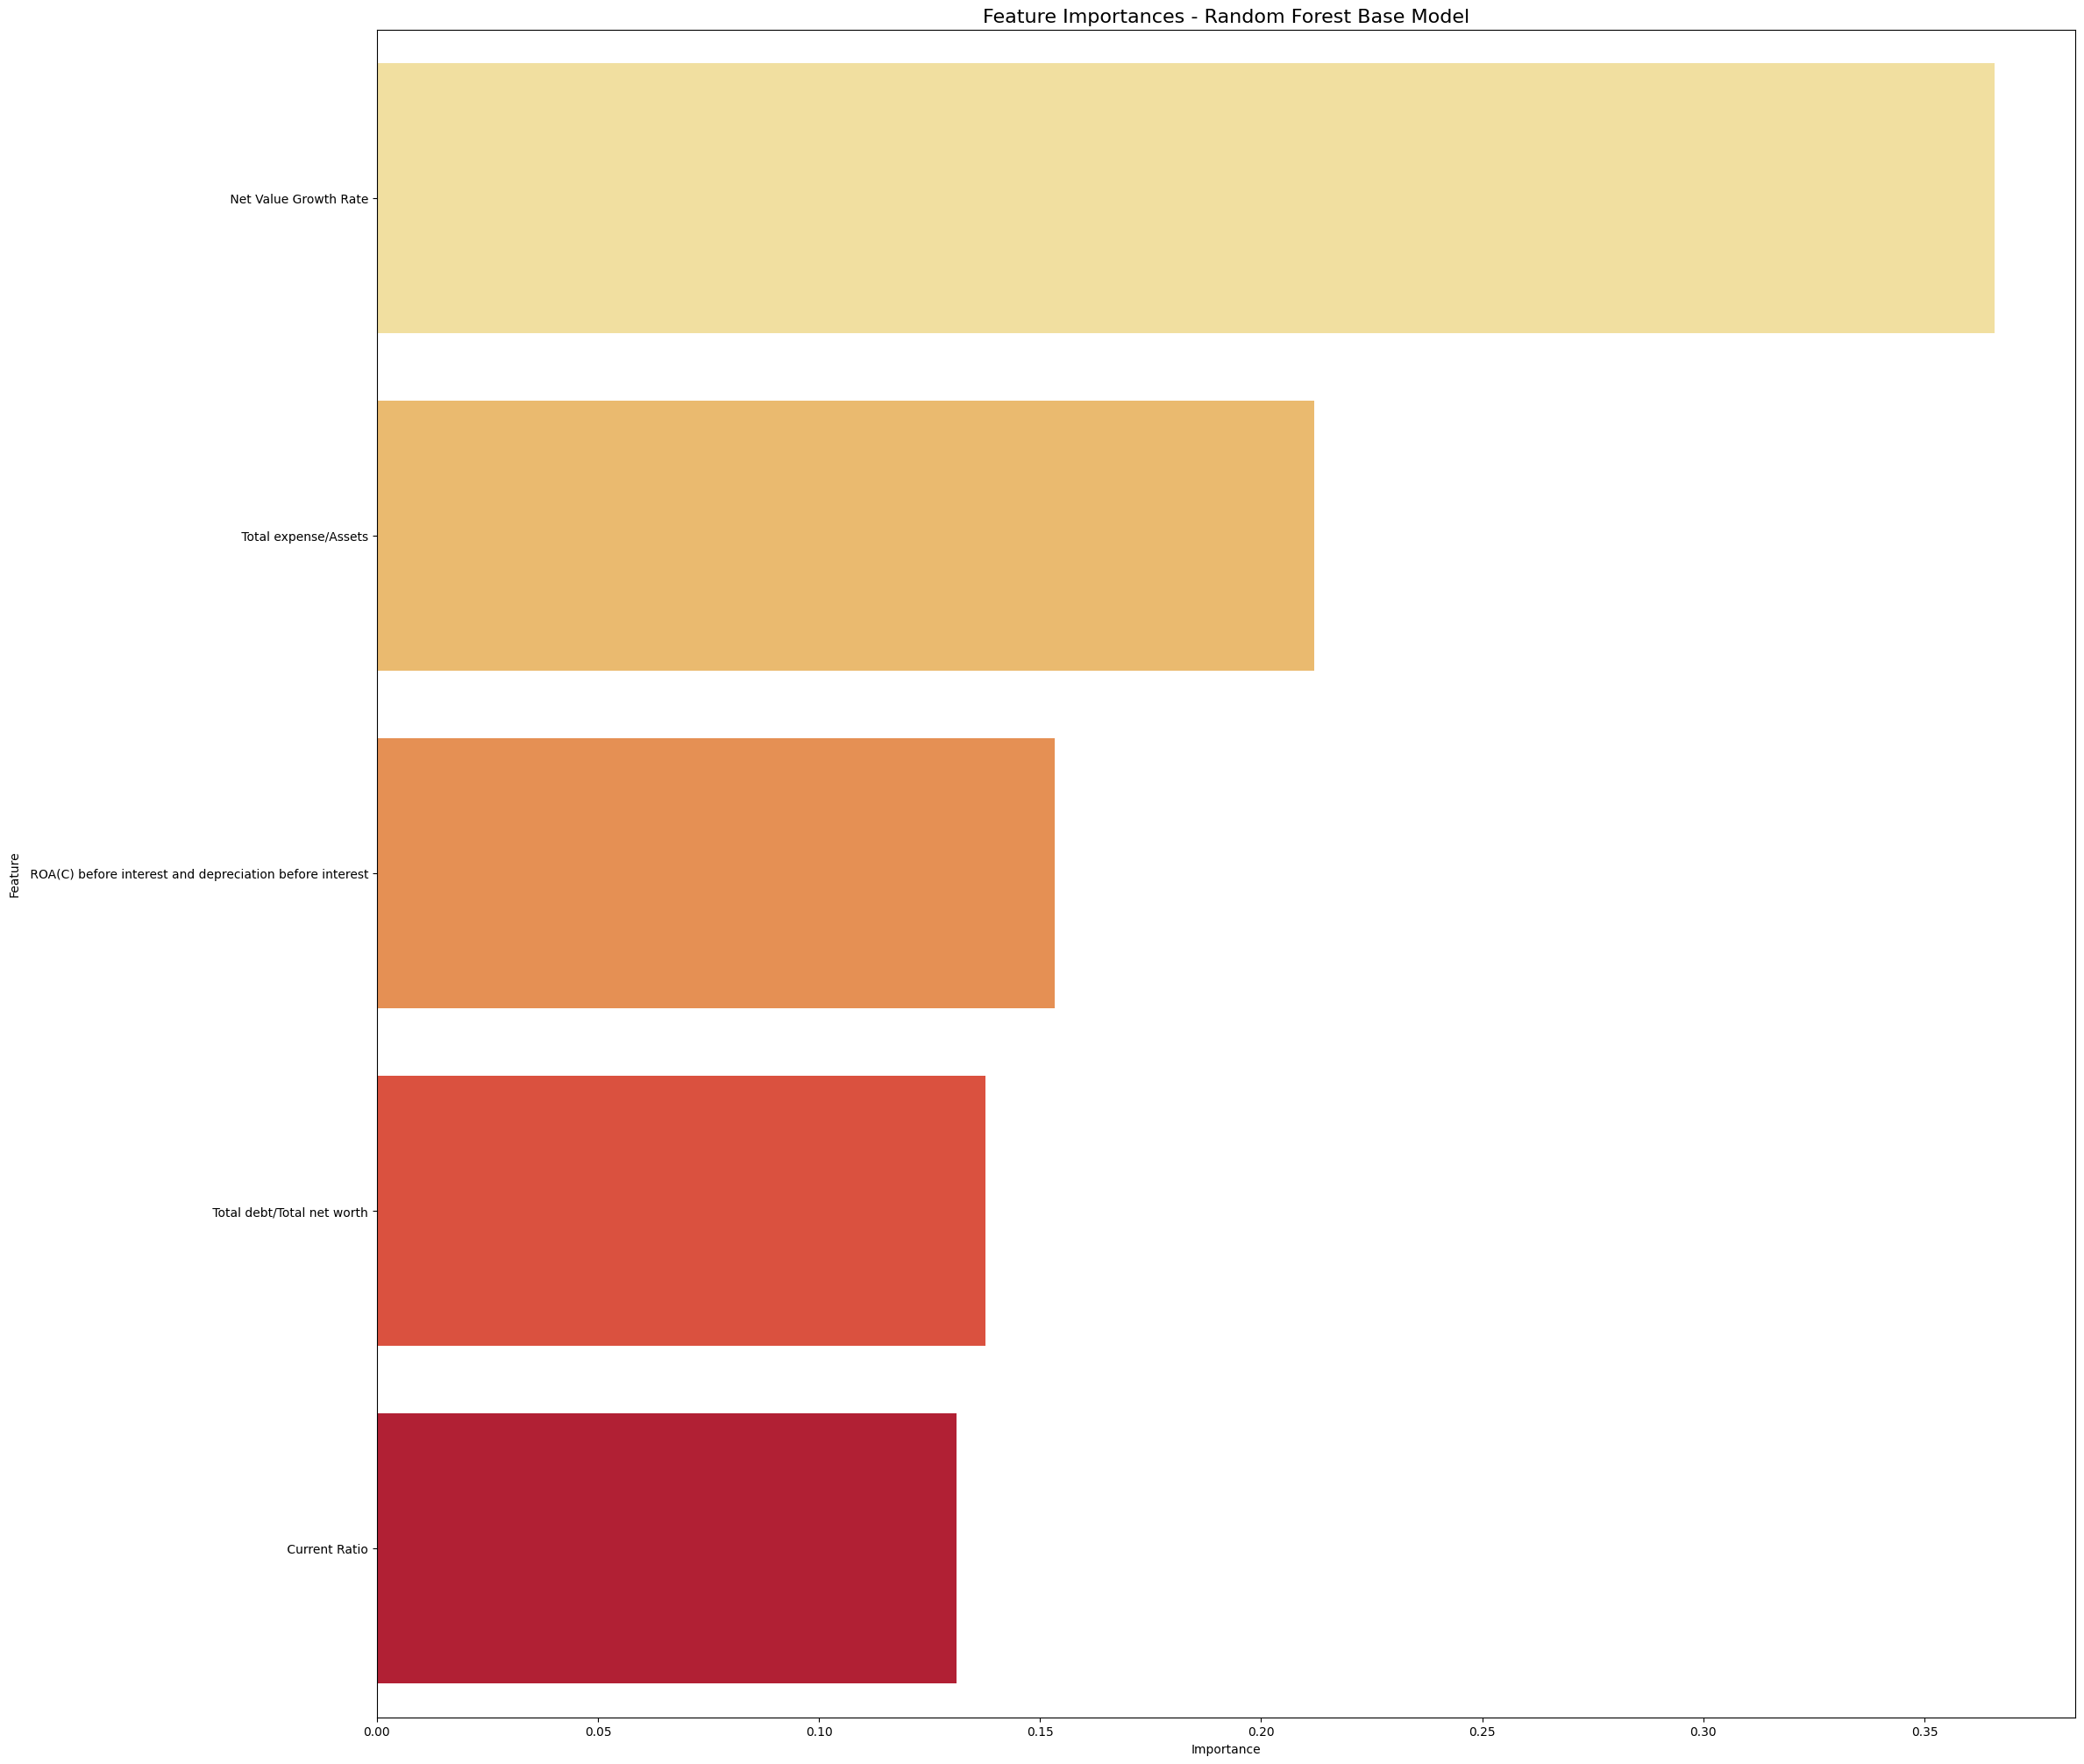

In [12]:
print("\nTraining stacking model fully on the entire cluster 3 data")
stacking_model.fit(X, y)

#  Feature Importance from Random Forest Base Model 
print("\nPlotting feature importances from Random Forest base model")
rf_model = stacking_model.named_estimators_['rf']
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(25,25))
sns.barplot(x=importances, 
            y=importances.index , 
            palette='YlOrRd',
            orient = 'h')
plt.title('Feature Importances - Random Forest Base Model', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### 📋 7. Final Report Table Row

In [7]:

avg_base_acc = np.mean(base_accs)
avg_tt = int(np.mean(tt_list))
avg_tf = int(np.mean(tf_list))

report_row = pd.DataFrame([{
    "Subgroup ID": 4,
    "Name of Student": "Khushi",
    "Average accuracy score base models [TT(TF)]": f"{avg_base_acc:.4f} [{avg_tt}({avg_tf})]",
    "Accuracy score Meta model [TT(TF)]": f"{stack_acc:.4f} [{TT_stack}({TF_stack})]",
    "N_features": 5
}])
report_row


,Subgroup ID,Name of Student,Average accuracy score base models [TT(TF)],Accuracy score Meta model [TT(TF)],N_features
0,4,Khushi,0.9879 [1171(14)],0.9907 [1175(11)],5


### 💾 8. Save Final Stacking Model

In [8]:

stacking_model.fit(X, y)
joblib.dump(stacking_model, 'khushi_cluster4_stacking_model_top5.joblib')
print("Model saved as 'khushi_cluster4_stacking_model_top5.joblib'")


Model saved as 'khushi_cluster4_stacking_model_top5.joblib'
